## 環境構築とライブラリの準備

本プロジェクトでは、XGBoostを用いた回帰モデルの構築と評価を目的として、以下の主要なライブラリやツールをインポートしている

### データ処理関連
- `pandas`, `numpy`: データの読み込み、前処理や数値計算に使用
- `random`: 乱数の制御（再現性確保のため）
- `train_test_split`: scikit-learnによるデータセットの学習用とテスト用への分割

### モデル構築・学習関連
- `xgboost`: 高性能な勾配ブースティングライブラリで、回帰モデルの構築に使用

### 評価指標
- `mean_squared_error`, `mean_absolute_error`, `r2_score`: 回帰モデルの性能評価に用いる指標

### 可視化関連
- `matplotlib`, `seaborn`: データ分布や学習結果の可視化に使用

### 再現性の確保
- 実験の再現性を担保するため、`random` と `numpy` の乱数シードを固定


In [8]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- 再現性の確保 ---
random.seed(42)
np.random.seed(42)

## データ前処理と特徴量エンジニアリング

体温・室温データから「適温」を予測するため、以下のような特徴量エンジニアリングと前処理を行いました。  
主にラグ特徴量・差分・移動統計量の導入による時系列的な情報の拡充を目的としています。

- データセット `ring_data.csv` または`ias_data.csv` を読み込み
- ラグ特徴量（1時刻前の体温・室温）  
  - `体温_lag1`, `室温_lag1`
- 差分特徴量（体温と室温の差とそのラグ）  
  - `delta_temp`, `delta_temp_lag1`
- 移動統計量（ウィンドウサイズ3）  
  - 移動平均：`体温_ma3`, `室温_ma3`  
  - 移動最大：`体温_max3`, `室温_max3`  
  - 移動最小：`体温_min3`, `室温_min3`
- 2次差分（温度差の加速度的変化）：`delta_temp_2diff`
- 欠損値の除去（`shift` や `rolling` によるNaNの削除）
- モデル入力として用いる特徴量を10種に選定
- 目的変数（ターゲット）は `適温` 列を使用
- 時系列の順序を保持したまま、学習用・テスト用にデータを8:2に分割（`shuffle=False`）




In [9]:
# --- データ読み込み ---
df = pd.read_csv("../datasets/ring_data.csv")

# --- ラグ特徴量 ---
df['体温_lag1'] = df['体温'].shift(1)
df['室温_lag1'] = df['室温'].shift(1)

# --- 差分特徴量 ---
df['delta_temp'] = df['室温'] - df['体温']
df['delta_temp_lag1'] = df['室温_lag1'] - df['体温_lag1']

# --- 移動平均、最大・最小（ウィンドウサイズ3） ---
window_size = 3
df['体温_ma3'] = df['体温'].rolling(window=window_size).mean()
df['体温_max3'] = df['体温'].rolling(window=window_size).max()
df['体温_min3'] = df['体温'].rolling(window=window_size).min()

df['室温_ma3'] = df['室温'].rolling(window=window_size).mean()
df['室温_max3'] = df['室温'].rolling(window=window_size).max()
df['室温_min3'] = df['室温'].rolling(window=window_size).min()

# --- 2次差分 ---
df['delta_temp_2diff'] = df['delta_temp'].diff()

# --- 欠損値除去 ---
df.dropna(inplace=True)

# --- 使用特徴量とターゲット ---
features = [
    '体温', '体温_lag1', '体温_ma3', '体温_max3', '体温_min3',
    '室温', '室温_lag1', '室温_ma3', '室温_max3', '室温_min3'
]
target = '適温'



# --- データ分割 ---
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)


## XGBoostによる回帰モデル構築と高精度化の工夫

### データ構造の最適化
- 学習データ・テストデータをXGBoostの高速処理に適した`DMatrix`形式に変換し、メモリ効率と処理速度を向上

###  ハイパーパラメータの詳細チューニング
- **目的関数**は回帰問題に適した`reg:squarederror`を選択。
- **評価指標**はRMSEを設定し、実際の誤差の大きさを直感的に把握可能にしました。
- **木の深さ**や**学習率**は過学習を防ぐために控えめな値を設定。
- **サブサンプリング**および**特徴量サンプリング**により、学習ごとに異なるデータと特徴を使うことでモデルの汎化性能を高めた
- L1正則化とL2正則化を導入し、不要なパラメータの影響を抑制
- **`min_child_weight=3`**と**`gamma=1.0`**により、分割時の条件を厳しく設定し、ノイズへの過適合を軽減。
- ツリー成長アルゴリズムに**hist**（高速ヒストグラム方式）と**lossguide**（損失減少に基づく成長方針）を指定し、大規模データに対しても効率的かつ精度良く学習可能にした


### 学習制御
- 最大2000ラウンドのブースティングを行う一方、**early_stopping_rounds=50**を設定し、検証データでの性能向上が見られなくなった時点で学習を終了。これにより過学習を防ぎつつ、計算資源を節約しました。
- 20ラウンドごとの進捗ログ出力で学習過程の把握も容易にしています。







In [10]:
# --- DMatrix作成 ---
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# --- パラメータ設定 ---
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'reg_alpha': 0.15,
    'reg_lambda': 1.2,
    'min_child_weight': 3,
    'gamma': 1.0,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'seed': 42
}
evals = [(dtrain, 'train'), (dtest, 'eval')]

# --- モデル学習 ---
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=20
)



[0]	train-rmse:1.57949	eval-rmse:0.94996


[20]	train-rmse:0.91519	eval-rmse:0.70854
[40]	train-rmse:0.55691	eval-rmse:0.68154
[60]	train-rmse:0.37182	eval-rmse:0.69861
[80]	train-rmse:0.28534	eval-rmse:0.72492
[81]	train-rmse:0.28305	eval-rmse:0.72618


### モデル評価
- テストデータに対して予測を行い、複数の指標で評価しました。
  - **MSE (Mean Squared Error)**：誤差の二乗平均で全体の精度を定量化
  - **RMSE (Root Mean Squared Error)**：誤差の大きさを直感的に把握できる単位で評価
  - **MAE (Mean Absolute Error)**：誤差の絶対値平均で外れ値の影響を軽減
  - **R²スコア (決定係数)**：モデルの説明力を示す指標

これらの多角的な評価により、モデルの予測精度と汎化性能のバランスを確認


In [11]:
# --- 予測と評価 ---
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

Test MSE: 0.5305
Test RMSE: 0.7283
Test MAE: 0.6227
Test R^2 Score: 0.3173


### 特徴量とターゲットとの相関関係の可視化


- 相関行列を `seaborn.heatmap` により可視化し、全体の傾向を直感的に把握できる
- 正の相関・負の相関が色で表現され、特徴量選定の参考となる
---

### XGBoostによる特徴量重要度の可視化


- どの特徴量がモデル予測に強く影響を与えているかを確認することで、**特徴量エンジニアリングやモデル解釈性の向上**に役立つ

---

### 実測値と予測値の比較プロット

- テストデータ部分に対応するインデックスを抽出し、**時間変化における予測の精度**を視覚的に確認可能

=== ターゲットとの相関係数 ===
適温         1.000000
室温         0.950770
室温_min3    0.945308
室温_ma3     0.942915
室温_lag1    0.940444
室温_max3    0.936912
体温_ma3     0.803161
体温_max3    0.782541
体温_min3    0.771660
体温_lag1    0.751599
体温         0.744581
Name: 適温, dtype: float64


c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\venv-py310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\venv-py310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\venv-py310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23460 (\N{CJK UNIFIED IDEOGRAPH-5BA4}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\venv-py310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 36969 (\N{CJK UNIFIED IDEOGRAPH-9069}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\bsk

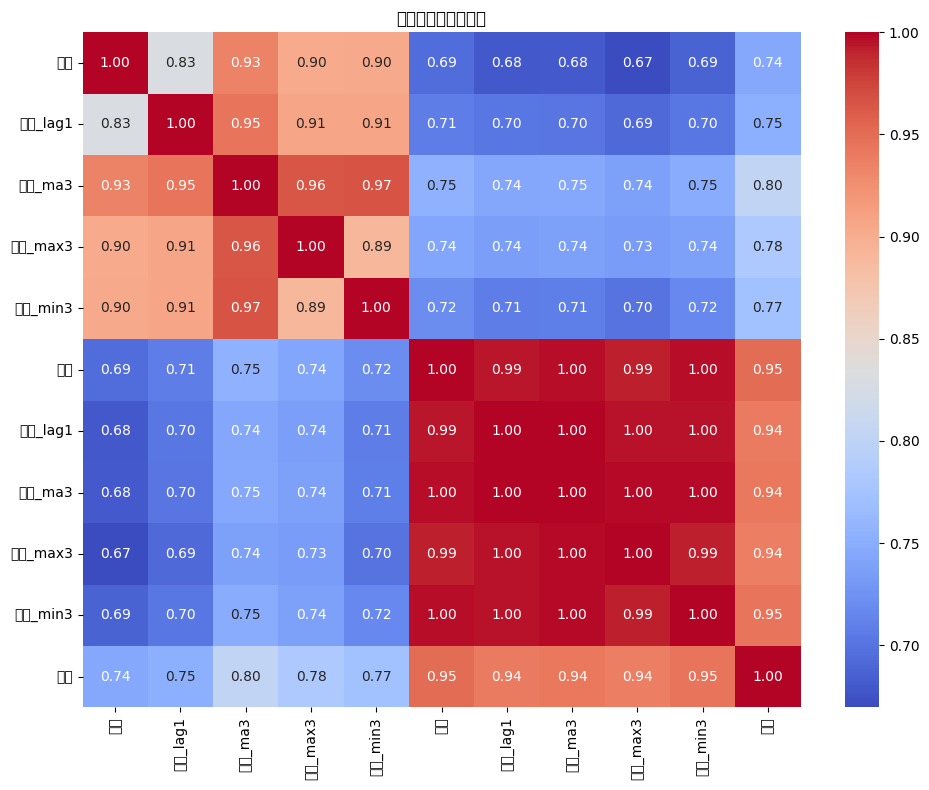


=== 特徴量重要度 ===
   feature  importance
5       室温       143.0
7   室温_ma3        41.0
9  室温_min3        39.0
2   体温_ma3        38.0
6  室温_lag1        26.0
8  室温_max3        14.0
4  体温_min3         7.0
0       体温         7.0
3  体温_max3         5.0
1  体温_lag1         0.0


C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:28: UserWarning: Glyph 23460 (\N{CJK UNIFIED IDEOGRAPH-5BA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:28: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:28: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:28: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:28: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:28: UserWarning: Glyph 37327 (\

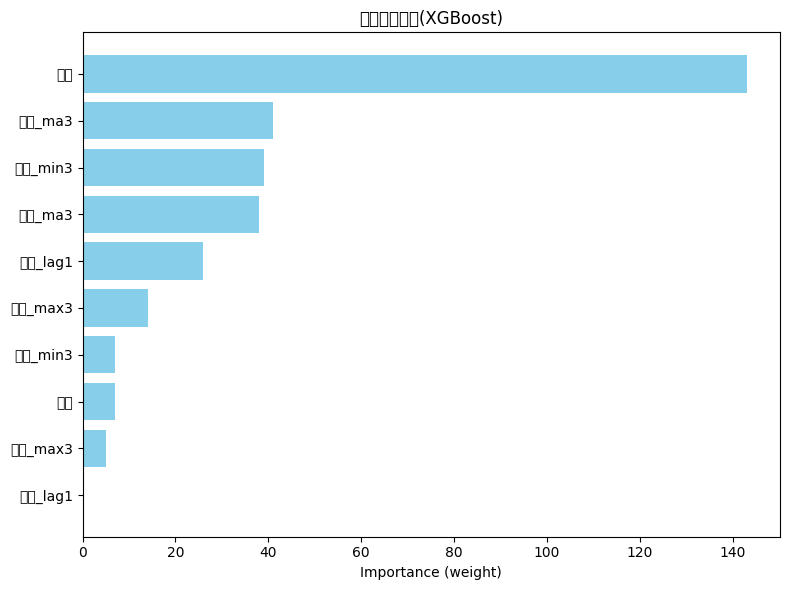

C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:43: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:43: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:43: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:43: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:43: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_16916\3601663021.py:43: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from 

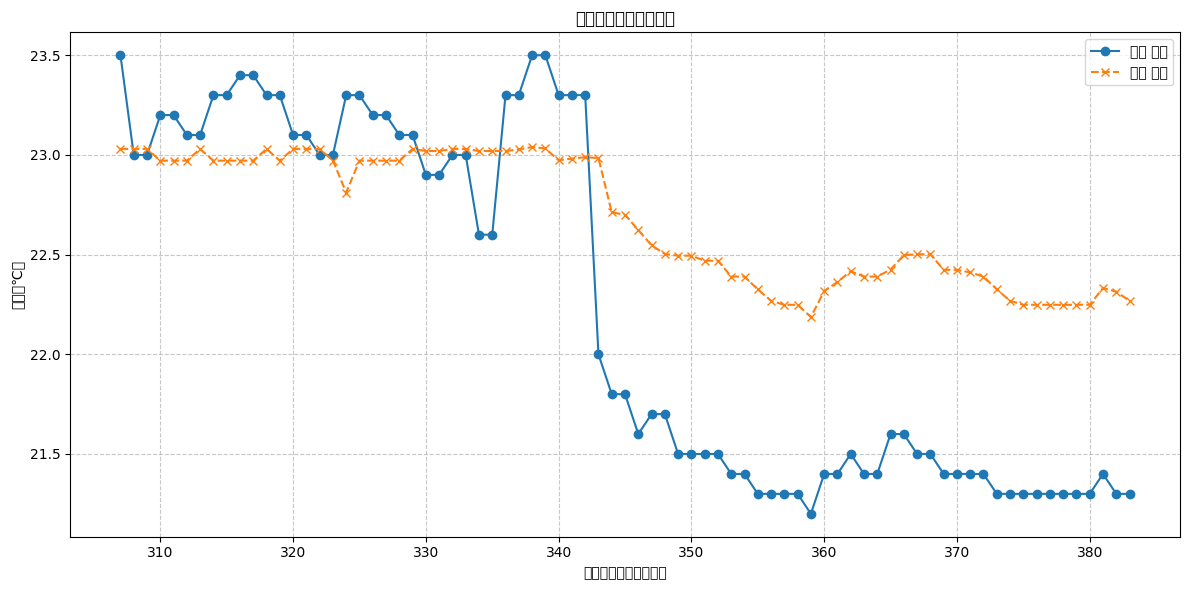

In [12]:
# --- 相関行列の表示 ---
corr_matrix = df[features + [target]].corr()

print("=== ターゲットとの相関係数 ===")
print(corr_matrix[target].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('特徴量間の相関行列')
plt.tight_layout()
plt.show()

# --- 特徴量重要度の取得と可視化（XGBoost） ---
importance = model.get_score(importance_type='weight')
feat_imp_df = pd.DataFrame({
    'feature': features,
    'importance': [importance.get(f'f{i}', 0) for i in range(len(features))]
}).sort_values(by='importance', ascending=False)

print("\n=== 特徴量重要度 ===")
print(feat_imp_df)

plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel('Importance (weight)')
plt.title('特徴量重要度(XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- 予測値と実測値の比較プロット ---
# 元データのインデックスのうち、テストデータ部分を取得
test_index = df.index[-len(y_test):]

plt.figure(figsize=(12, 6))
plt.plot(test_index, y_test, label='実測 適温', marker='o', linestyle='-')
plt.plot(test_index, y_pred, label='予測 適温', marker='x', linestyle='--')
plt.xlabel('インデックス（時間）')
plt.ylabel('適温（℃）')
plt.title('実測値と予測値の比較')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



**CSVファイルへの保存**  
   指定したファイル名（`ring_xgb.csv`）でCSV形式で`.\results`へ保存し、保存パスを出力している



In [13]:
import os


# 評価指標を辞書でまとめる
results_dict = {
    "MSE": [mse],
    "RMSE": [rmse],
    "MAE": [mae],
    "R2": [r2]
}

# DataFrameに変換
results_df = pd.DataFrame(results_dict)

# 保存先ディレクトリ
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)  # フォルダがなければ作成

# 保存ファイル名
filename = "ring_xgb.csv"  

# フルパスを作成
filepath = os.path.join(results_dir, filename)

# CSV保存（indexは不要）
results_df.to_csv(filepath, index=False)

print(f"評価結果を保存しました: {filepath}")


評価結果を保存しました: ../results\ring_xgb.csv
